In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly

In [2]:
cd ..

/home/chuwen/workspace/abip-lp


In [3]:
# %run -i bench-lp/analyze.crs.py --conf bench-lp/conf/netlib.crs.analyze.json 
%run -i bench-lp/analyze_crs.py --conf bench-lp/conf/mip17.crs.json 

2023-07-08 15:31:21,296 INFO @analyze registered methods [{'name': 'google_pdhg_1e-4', 'solution_dir': 'pdhg_cpp_1e-4-cross', 'affix': '.json'}, {'name': 'google_pdhg_1e-6', 'solution_dir': 'pdhg_cpp_1e-6-cross', 'affix': '.json'}, {'name': 'google_pdhg_1e-8', 'solution_dir': 'pdhg_cpp_1e-8-cross', 'affix': '.json'}, {'name': 'abip_direct_1e-6', 'solution_dir': 'abip_0_1e-6-cross', 'affix': '.json'}, {'name': 'abip_direct_1e-4', 'solution_dir': 'abip_0_1e-4-cross', 'affix': '.json'}]
2023-07-08 15:31:21,297 DEBUG @analyze try {'name': 'google_pdhg_1e-4', 'solution_dir': 'pdhg_cpp_1e-4-cross', 'affix': '.json'}
2023-07-08 15:31:21,298 DEBUG @analyze analyze {'name': 'google_pdhg_1e-4', 'solution_dir': 'pdhg_cpp_1e-4-cross', 'affix': '.json'} @ lp-test-results/mipcol17/pdhg_cpp_1e-4-cross
2023-07-08 15:31:21,307 INFO @analyze google_pdhg_1e-4 solution finished
2023-07-08 15:31:21,308 DEBUG @analyze try {'name': 'google_pdhg_1e-6', 'solution_dir': 'pdhg_cpp_1e-6-cross', 'affix': '.json'}



\documentclass{article}
\usepackage{lscape,longtable,multirow}
\usepackage{booktabs,caption}
\begin{document}
    
\begin{longtable}{lrrr}
\caption{Number of solved instances}\\
\toprule
{} &  status &    iteration &      time \\
method           &         &              &           \\
\midrule
\endfirsthead
\caption[]{Number of solved instances} \\
\toprule
{} &  status &    iteration &      time \\
method           &         &              &           \\
\midrule
\endhead
\midrule
\multicolumn{4}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
abip\_direct\_1e-4 &     213 &  1014.492515 &  0.825972 \\
abip\_direct\_1e-6 &     196 &   575.266268 &  0.453987 \\
google\_pdhg\_1e-4 &     232 &   956.724678 &  0.947923 \\
google\_pdhg\_1e-6 &     234 &   721.517272 &  0.653200 \\
\end{longtable}

    
\end{document}
    


/home/chuwen/workspace/abip-lp/bench-lp/analyze_crs.py:154: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  {df_sum.to_latex(multirow=True,longtable=True, multicolumn=True, caption='Number of solved instances')}


In [4]:
METHOD_RENAME={
    "abip_direct_1e-4": r"$\text{abip}, 10^{-4}$",
    "abip_direct_1e-6": r"$\text{abip}, 10^{-6}$",
    "google_pdhg_1e-4": r"$\text{pdlp}, 10^{-4}$",
    "google_pdhg_1e-6": r"$\text{pdlp}, 10^{-6}$"
}
# df_plot_all = df_agg_suc[
#  df_agg_suc['method'].apply(lambda x: x.endswith("6"))
# ]
# data_support = pd.read_csv("./bench-lp/mip17bench.csv").rename(
#     columns={'Instance  Ins.': 'real_name'}
# ).set_index('real_name')
# df_plot_all = df_plot_all.join(data_support, on='real_name', how='left')
# df_plot = df_plot_all[df_plot_all["Variables  Var."] > 0]
if False:
    pass
else:
    df_plot_all = df_agg_suc.assign(
        group=lambda df: df['method'].apply(lambda x: x[-1])
    ).assign(
        method=lambda df: df['method'].apply(lambda x: METHOD_RENAME.get(x, x))
    ).set_index(
        ["method", "real_name", "group"]
    )

In [5]:
df_min = df_plot_all.groupby(["real_name", "group"]).agg(
    {"iteration": min, "time": min, "bool_fail": 'count'}
)

In [6]:
df_plot = df_plot_all.join(
    df_min, on=['real_name', 'group'], 
    lsuffix= '', rsuffix= '-', how='left'
).assign(
    alphat=lambda df: df['time']/df['time-'],    
    alphai=lambda df: df['iteration']/(df['iteration-'] + 1),
    bettert=lambda df: df['alphat'].apply(lambda x: x <= 1),
    betteri=lambda df: df['alphai'].apply(lambda x: x <= 1)
).sort_index(
    level=['real_name', 'group']
).reset_index(level=2)
# both succeeded
df_plot = df_plot[df_plot['bool_fail-'] == 2] 

In [7]:
df_plot.query('group == "4"').groupby('method').name.count()

method
$\text{abip}, 10^{-4}$    212
$\text{pdlp}, 10^{-4}$    212
Name: name, dtype: int64

In [8]:
df_plot.groupby("method")['bettert'].sum()

method
$\text{abip}, 10^{-4}$     72
$\text{abip}, 10^{-6}$     71
$\text{pdlp}, 10^{-4}$    140
$\text{pdlp}, 10^{-6}$    125
Name: bettert, dtype: int64

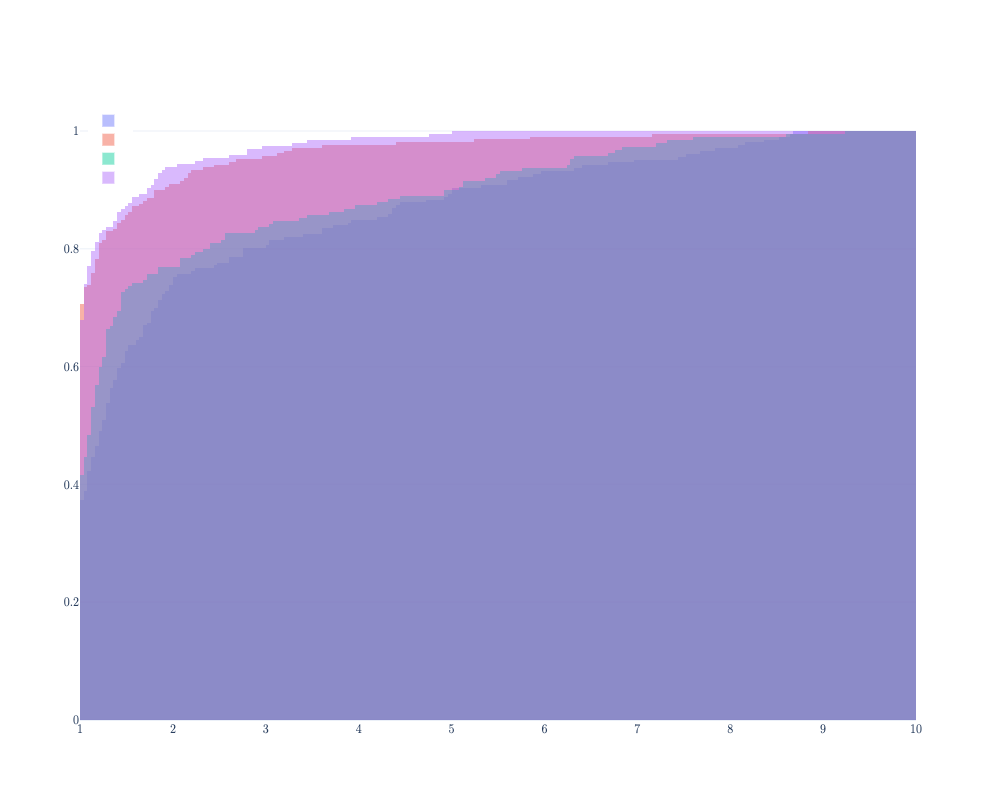

In [13]:
fig = go.Figure()
for mm in df_plot.index.get_level_values(0).unique():
# for mm in df_plot.index.get_level_values(0).unique():
    fig.add_trace(
        go.Histogram(
            # x=df_plot.loc[mm, 'time'].values,
            # x=np.log((df_plot.loc[mm, 'time'].values + 1).tolist()),
            # x=df_plot.loc[mm, 'time']/(df_min['time'] + 1),
            x=df_plot.loc[mm, 'alphat'],
            name=mm,
            xbins=dict(
                start=0,
                end=10,
                size=0.04
            ),
            cumulative_enabled=True,
            histnorm='probability',
        ) 
    )

# Overlay both histograms
fig.update_layout(
    width=1080, height=800,
    barmode='overlay',
    font_family="Latin Modern Roman",
    title_font_family="Latin Modern Roman",
    legend_font_family="Latin Modern Roman",
    xaxis_title=r"$\alpha$", 
    yaxis_title=r"$P(\alpha)$: Percentage of Successful Instances",
    template = 'plotly_white',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.45)
fig.show()


In [14]:
fig.write_image("fig.pdf")
fig.write_html("fig.html", include_mathjax="cdn")

In [11]:
%run -i bench-lp/pdlp_solve.py --file ../abip-lp/datasets/netlib/unpacked/pre_afiro.mps

(CVXPY) Jul 08 03:31:23 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jul 08 03:31:23 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
Read MPS format model from file ../abip-lp/datasets/netlib/unpacked/pre_afiro.mps


2023-07-08 15:31:23,392 INFO gurobipy.gurobipy Read MPS format model from file ../abip-lp/datasets/netlib/unpacked/pre_afiro.mps


Reading time = 0.00 seconds


2023-07-08 15:31:23,394 INFO gurobipy.gurobipy Reading time = 0.00 seconds


matlab: 18 rows, 28 columns, 57 nonzeros


2023-07-08 15:31:23,395 INFO gurobipy.gurobipy matlab: 18 rows, 28 columns, 57 nonzeros


termination_criteria {
  eps_optimal_absolute: 1e-08
  eps_optimal_relative: 1e-08
  eps_primal_infeasible: 1e-12
  eps_dual_infeasible: 1e-12
  time_sec_limit: 3600
}
verbosity_level: 2
presolve_options {
  use_glop: false
}

Primal solution: [ 80.00000008  69.05148171   0.           0.           0.
   0.           0.           0.          18.21428578 499.99999998
   0.         339.94285691   0.          10.94851848   0.
   0.          50.83719566 363.15836113 226.80542957   0.
 214.25140529 283.30288679 312.8135     349.18704651  38.98671411
   0.         500.501       17.55814292]
Dual solution: [-1.56340675e-01 -3.42857155e-01 -2.28571418e-01 -9.11164595e-10
 -1.49732171e-01 -1.54609833e-01 -3.17346471e-09 -5.21459446e-09
 -8.12413444e-10 -3.44771412e-01 -1.06879542e-09  1.88061496e-16
  1.86716512e-16 -1.86716512e-16 -3.35106021e-09 -8.74342874e-01
  0.00000000e+00  4.92700493e-09]
Reduced costs: [0.00000000e+00 1.23724648e-09 1.56340674e-01 1.49732170e-01
 1.54609832e-01 1.548991

I0000 00:00:1688801483.398576 2819563 primal_dual_hybrid_gradient.cc:842] Problem stats before rescaling:
I0000 00:00:1688801483.398686 2819563 primal_dual_hybrid_gradient.cc:1088] There are 28 variables, 18 constraints, and 57 constraint matrix nonzeros.
I0000 00:00:1688801483.398705 2819563 primal_dual_hybrid_gradient.cc:1094] Absolute values of nonzero constraint matrix elements: largest=1.400000, smallest=0.109000, avg=0.927020
I0000 00:00:1688801483.398716 2819563 primal_dual_hybrid_gradient.cc:1099] Constraint matrix, infinity norm: max(row & col)=1.400000, min_col=1.000000, min_row=1.000000
I0000 00:00:1688801483.398735 2819563 primal_dual_hybrid_gradient.cc:1104] Constraint bounds statistics (max absolute value per row): largest=500.501000, smallest=44.000000, avg=174.878296, l2_norm=1056.702939
I0000 00:00:1688801483.398744 2819563 primal_dual_hybrid_gradient.cc:1121] Absolute values of objective vector elements: largest=0.600000, smallest=0.219400, avg=0.077707, l2_norm=1.024

In [12]:
pwd

'/home/chuwen/workspace/abip-lp'